Modified from:
https://github.com/CAREamics/careamics-examples/blob/main/applications/n2v/channels/W2S_N2V.ipynb

In [1]:
# Imports necessary to execute the code
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import pooch
import tifffile
from careamics import CAREamist
from careamics.config import create_n2v_configuration

# use n2v2
use_n2v2 = False

# folder in which to save all the data
root = Path("w2s")



## Import the dataset

In [20]:
from bioio import BioImage
import bioio_bioformats

img = BioImage(r"C:\Users\maart\Downloads\MAX_241015_R54ko_G6_2s_zstack_IR_05_w1SPD G_t1.tif",reader=bioio_bioformats.Reader)

In [21]:
img.shape

(301, 1, 1, 512, 512)

## Visualize data

(301, 1, 1, 512, 512)


Text(0.5, 1.0, 'T 100')

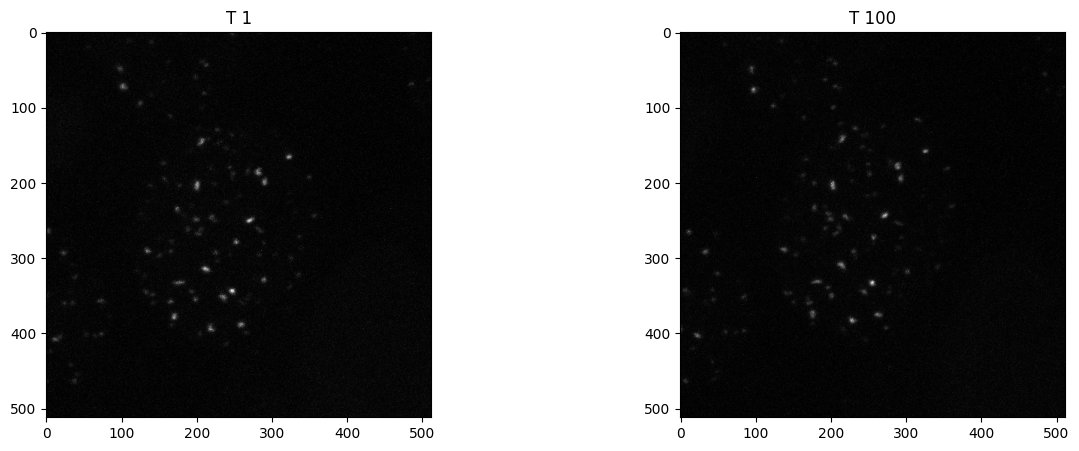

In [22]:
print(img.shape)
fig, ax = plt.subplots(1, 2, figsize=(15, 5))
ax[0].imshow(img.data[1][0][0], cmap="gray")
ax[0].set_title("T 1")
ax[1].imshow(img.data[100][0][0], cmap="gray")
ax[1].set_title("T 100")

## Train with CAREamics

### Create configuration


In [35]:
# create configuration
algo = "n2v2" if use_n2v2 else "n2v"

config = create_n2v_configuration(
    experiment_name="w2s_" + algo,
    data_type="array",
    axes="SYX",
    patch_size=(64,64),
    batch_size=32,
    num_epochs=15,
    n_channels=1,
    use_n2v2=use_n2v2,
)

print(config)

{'algorithm_config': {'algorithm': 'n2v',
                      'loss': 'n2v',
                      'lr_scheduler': {'name': 'ReduceLROnPlateau',
                                       'parameters': {}},
                      'model': {'architecture': 'UNet',
                                'conv_dims': 2,
                                'depth': 2,
                                'final_activation': 'None',
                                'in_channels': 1,
                                'independent_channels': True,
                                'n2v2': False,
                                'num_channels_init': 32,
                                'num_classes': 1,
                                'use_batch_norm': True},
                      'n2v_config': {'masked_pixel_percentage': 0.2,
                                     'name': 'N2VManipulate',
                                     'remove_center': True,
                                     'roi_size': 11,
                    

In [36]:
input = img.data
input.shape
input = np.squeeze(input)

In [37]:
print(input.shape)

(301, 512, 512)


### Train

In [38]:
# instantiate a CAREamist
careamist = CAREamist(
    source=config,
    work_dir=root / algo,
)

# train
careamist.train(
    train_source=input,
    val_percentage=0.0,
    val_minimum_split=10,  # use 10 patches as validation
)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
Computed dataset mean: [1281.58483283], std: [314.82044216]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type | Params | Mode 
---------------------------------------
0 | model | UNet | 333 K  | train
---------------------------------------
333 K     Trainable params
0         Non-trainable params
333 K     Total params
1.335     Total estimated model params size (MB)
39        Modules in train mode
0         Modules in eval mode


Sanity Checking: |                                                                               | 0/? [00:00<…

RuntimeError: Please call `iter(combined_loader)` first.

## Predict 

In [19]:
prediction = careamist.predict(
    source=input,
    tile_size=(256, 256),
    tile_overlap=(48, 48),
    batch_size=1,
)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/maarten/miniforge3/envs/careamics/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=31` in the `DataLoader` to improve performance.


Predicting: |          | 0/? [00:00<?, ?it/s]

### Save predictions

In [20]:
pred_folder = root / ("results_" + algo)
pred_folder.mkdir(exist_ok=True, parents=True)

final_data = np.concatenate(prediction)
tifffile.imwrite(pred_folder / "prediction.tiff", final_data)

### Visualize the prediction

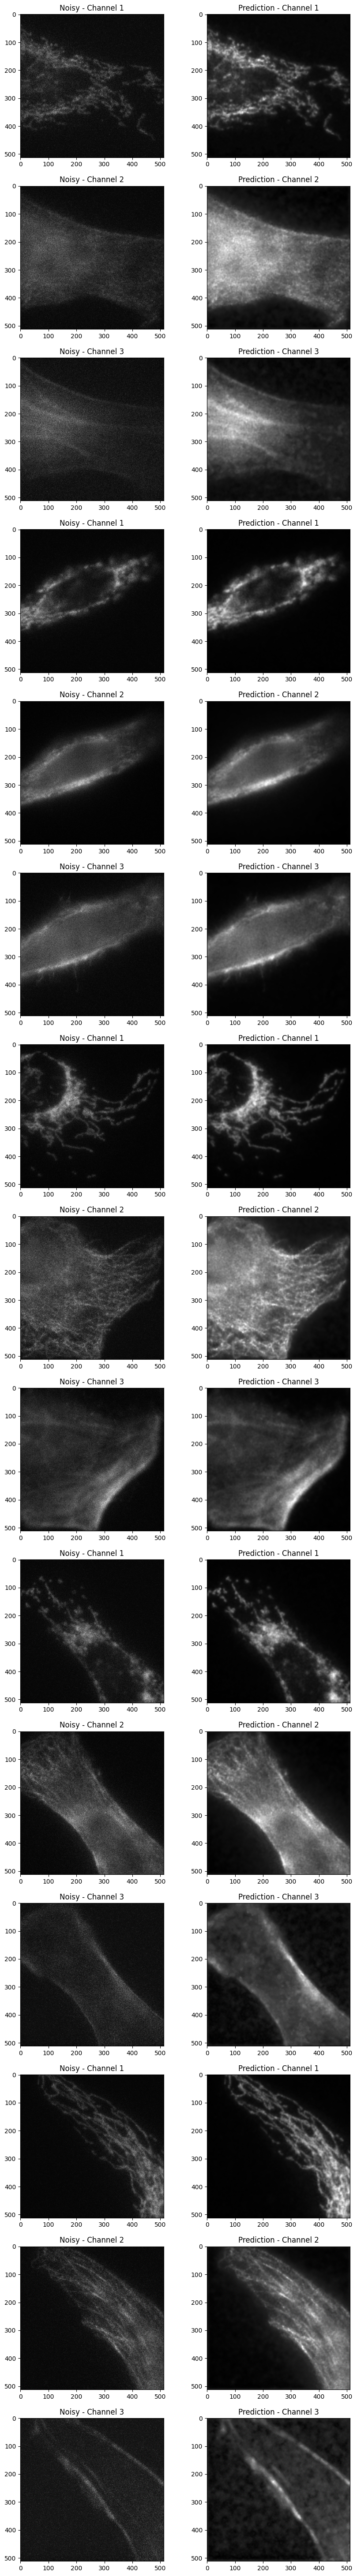

In [8]:
n = 5

fig, ax = plt.subplots(3 * n, 2, figsize=(10, 3 * n * 5))
for i in range(n):
    row = 3 * i

    # channel 1
    ax[row, 0].imshow(train_image[i, 0], cmap="gray")
    ax[row, 0].set_title("Noisy - Channel 1")
    ax[row, 1].imshow(prediction[i].squeeze()[0], cmap="gray")
    ax[row, 1].set_title("Prediction - Channel 1")

    # channel 2
    ax[row + 1, 0].imshow(train_image[i, 1], cmap="gray")
    ax[row + 1, 0].set_title("Noisy - Channel 2")
    ax[row + 1, 1].imshow(prediction[i].squeeze()[1], cmap="gray")
    ax[row + 1, 1].set_title("Prediction - Channel 2")

    # channel 3
    ax[row + 2, 0].imshow(train_image[i, 2], cmap="gray")
    ax[row + 2, 0].set_title("Noisy - Channel 3")
    ax[row + 2, 1].imshow(prediction[i].squeeze()[2], cmap="gray")
    ax[row + 2, 1].set_title("Prediction - Channel 3")

## Cover

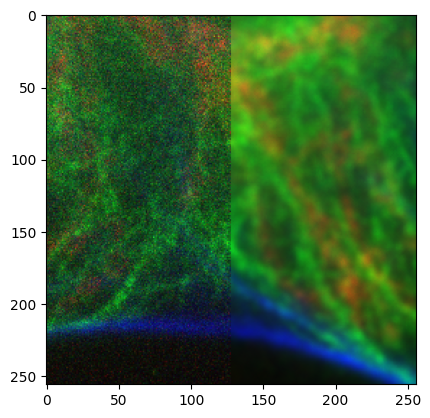

In [9]:
# create a cover image
im_idx = 8
cv_image_noisy = train_image[im_idx]
cv_image_pred = prediction[im_idx].squeeze()

# create image
cover = np.zeros((3, 256, 256))
(_, height, width) = cv_image_noisy.shape
assert height > 256
assert width > 256

# get min and max and reshape them so that they can be broadcasted with the images
noise_min = np.array(np.min(cv_image_noisy, axis=(1, 2)))[
    (..., *[np.newaxis] * (cv_image_noisy.ndim - 1))
]
noise_max = np.array(np.max(cv_image_noisy, axis=(1, 2)))[
    (..., *[np.newaxis] * (cv_image_noisy.ndim - 1))
]
pred_min = np.array(np.min(cv_image_pred, axis=(1, 2)))[
    (..., *[np.newaxis] * (cv_image_pred.ndim - 1))
]
pred_max = np.array(np.max(cv_image_pred, axis=(1, 2)))[
    (..., *[np.newaxis] * (cv_image_pred.ndim - 1))
]

# normalize train and prediction per channel
norm_noise = (cv_image_noisy - noise_min) / (noise_max - noise_min)
norm_pred = (cv_image_pred - pred_min) / (pred_max - pred_min)

# fill in halves
cover[:, :, : 256 // 2] = norm_noise[
    :,
    height // 2 - 256 // 2 : height // 2 + 256 // 2,
    width // 2 - 256 // 2 : width // 2,
]
cover[:, :, 256 // 2 :] = norm_pred[
    :,
    height // 2 - 256 // 2 : height // 2 + 256 // 2,
    width // 2 : width // 2 + 256 // 2,
]

# move C axis at the end
cover = np.moveaxis(cover, 0, -1)

# plot the single image
plt.imshow(cover)

# save the image
plt.imsave("W2S_N2V.jpeg", cover)